In [1]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19 LTS; OpenJDK Runtime Environment Zulu11.56+19-CA (build 11.0.15+10-LTS); OpenJDK 64-Bit Server VM Zulu11.56+19-CA (build 11.0.15+10-LTS, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6s/z3758tx16yd17yy35vnsnx_80000gn/T/tmp35avmywf
  JVM stdout: /var/folders/6s/z3758tx16yd17yy35vnsnx_80000gn/T/tmp35avmywf/h2o_davidnunez_started_from_python.out
  JVM stderr: /var/folders/6s/z3758tx16yd17yy35vnsnx_80000gn/T/tmp35avmywf/h2o_davidnunez_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Asuncion
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,2 months and 28 days
H2O_cluster_name:,H2O_from_python_davidnunez_l72caj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:
import pandas as pd
df = pd.read_csv('../df_dummizado_up_to_2021.csv', index_col=False)

df_complaints = df[(df['Protestas'] == True)]
df_no_complaints = df[(df['Protestas'] == False)]

n_cmp = len(df_complaints.index)
n_no_cmp = len(df_no_complaints.index)
df_no_complaints = df_no_complaints.sample(int(n_cmp*3/2)) #Sample 60% no complaints 40 % complaints
balanced_df = pd.concat([df_complaints, df_no_complaints])

In [3]:
balanced_df.shape

(12242, 933)

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(balanced_df, test_size=0.2, random_state=42)
train = h2o.H2OFrame.from_python(train_data)
test = h2o.H2OFrame.from_python(test_data)
# Identify predictors and response
y = "Protestas"
x = train.columns
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leader
# board
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
23:10:13.830: AutoML: XGBoost is not available; skipping it.
23:10:13.854: _train param, Dropping bad and constant columns: [contracts.investmentProjects.id_6, contracts.investmentProjects.id_31, contracts.investmentProjects.id_30, contracts.investmentProjects.id_35, contracts.investmentProjects.id_36, contracts.investmentProjects.id_34, contracts.investmentProjects.id_37, parties.details.legalEntityTypeDetail buyer_15, parties.details.legalEntityTypeDetail buyer_14, parties.details.legalEntityTypeDetail buyer_13, parties.details.legalEntityTypeDetail buyer_12, parties.details.legalEntityTypeDetail buyer_11, parties.details.legalEntityTypeDetail buyer_10, parties.details.EntityType payee_1, parties.details.EntityType payee_2, parties.details.EntityType payee_3, contracts.investmentProjects.id_24, contracts.investmentProjects.id_109, parties.details.EntityType payee_4, contracts.investmentProjects.id_106, planning.items.classification.id.n1_1_56, planning.items.classi

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20230726_231013,0.908264,0.369347,0.884297,0.168563,0.339396,0.11519
StackedEnsemble_BestOfFamily_1_AutoML_1_20230726_231013,0.905714,0.372701,0.883353,0.171789,0.341203,0.11642
GBM_grid_1_AutoML_1_20230726_231013_model_5,0.904327,0.380085,0.879318,0.171487,0.343178,0.117771
GBM_grid_1_AutoML_1_20230726_231013_model_4,0.903064,0.381222,0.872596,0.173623,0.345105,0.119098
GBM_4_AutoML_1_20230726_231013,0.901638,0.381724,0.877174,0.17397,0.344836,0.118912
GBM_grid_1_AutoML_1_20230726_231013_model_1,0.899681,0.386639,0.872467,0.177469,0.347389,0.120679
GBM_3_AutoML_1_20230726_231013,0.89926,0.387236,0.87034,0.180337,0.348187,0.121234
GBM_1_AutoML_1_20230726_231013,0.898276,0.390865,0.864621,0.180046,0.350591,0.122914
GBM_2_AutoML_1_20230726_231013,0.896558,0.392327,0.866029,0.18212,0.350684,0.122979
GBM_5_AutoML_1_20230726_231013,0.894601,0.396337,0.863676,0.18189,0.352736,0.124423


In [5]:
preds = aml.predict(test)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20230726_231013,0.922341,0.341412,0.909979,0.151402,0.324484,0.10529,66246,0.383775,StackedEnsemble
GBM_grid_1_AutoML_1_20230726_231013_model_1,0.918753,0.349727,0.903841,0.156049,0.32898,0.108228,4308,0.087144,GBM
GBM_grid_1_AutoML_1_20230726_231013_model_4,0.918097,0.350912,0.901923,0.154015,0.329686,0.108693,4700,0.086048,GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20230726_231013,0.917264,0.348174,0.90671,0.151362,0.327837,0.107477,16602,0.105001,StackedEnsemble
GBM_4_AutoML_1_20230726_231013,0.917121,0.35192,0.901815,0.152437,0.329262,0.108413,5533,0.140539,GBM
GBM_grid_1_AutoML_1_20230726_231013_model_5,0.914889,0.355611,0.901966,0.152784,0.330103,0.108968,8150,0.024827,GBM
GBM_3_AutoML_1_20230726_231013,0.911384,0.361862,0.896685,0.161078,0.334014,0.111565,4397,0.067096,GBM
GBM_1_AutoML_1_20230726_231013,0.910169,0.367644,0.88983,0.165461,0.337262,0.113746,5738,0.046322,GBM
GBM_2_AutoML_1_20230726_231013,0.909909,0.369247,0.891211,0.167868,0.33897,0.1149,3723,0.113513,GBM
GBM_5_AutoML_1_20230726_231013,0.906989,0.375255,0.888625,0.164187,0.340941,0.11624,3227,0.039742,GBM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20230726_231013

,False,True,Error,Rate
False,1289.0,158.0,0.1092,(158.0/1447.0)
True,194.0,808.0,0.1936,(194.0/1002.0)
Total,1483.0,966.0,0.1437,(352.0/2449.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

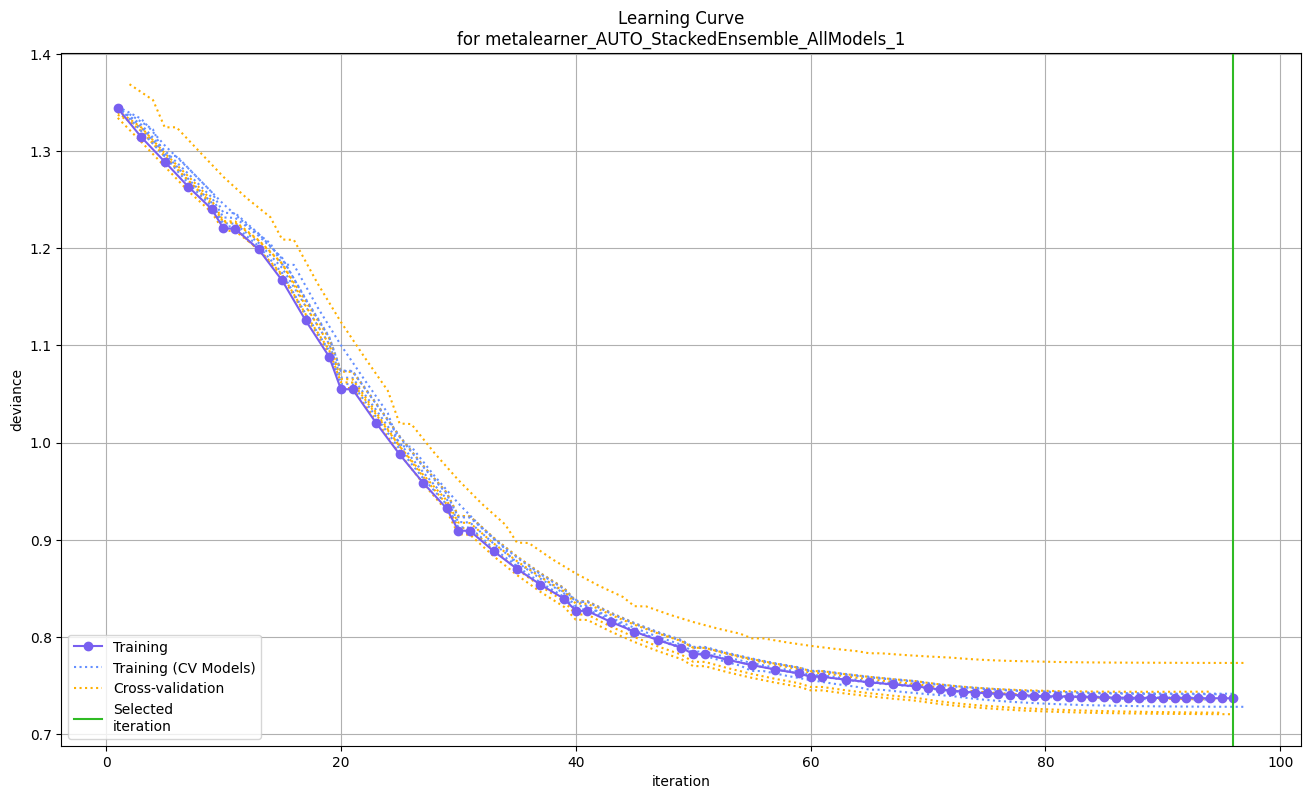

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

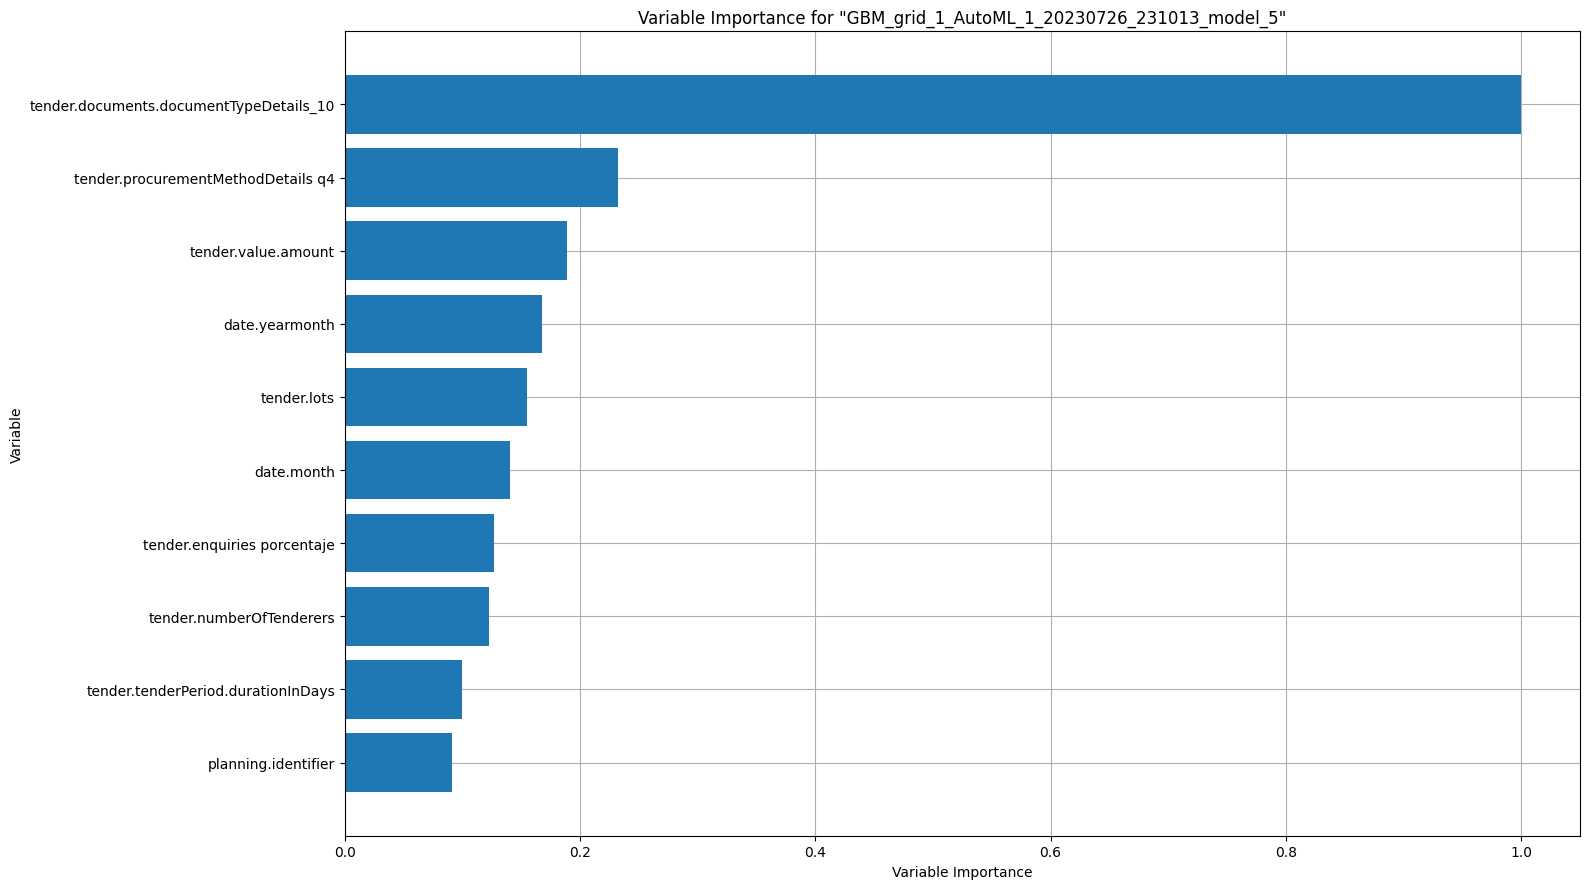

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

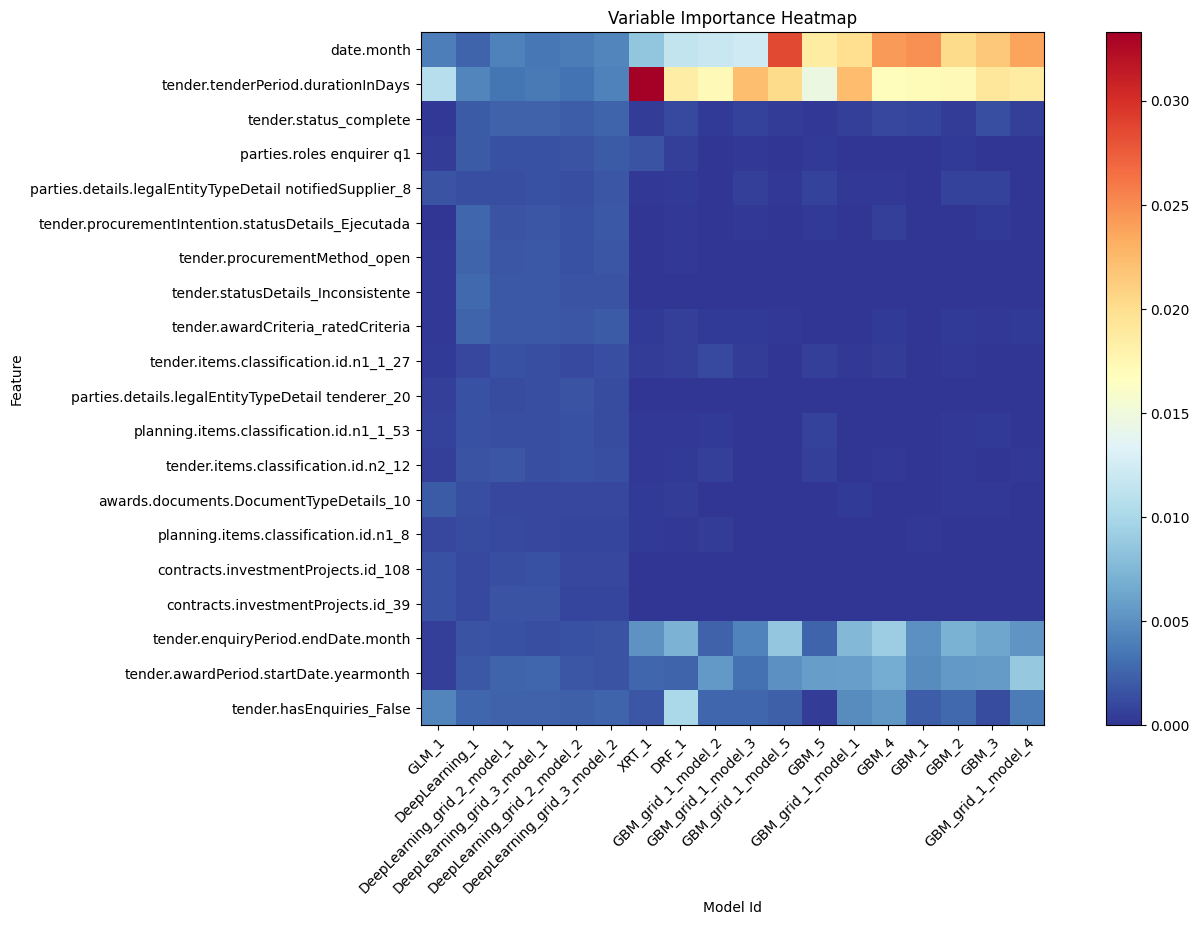

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

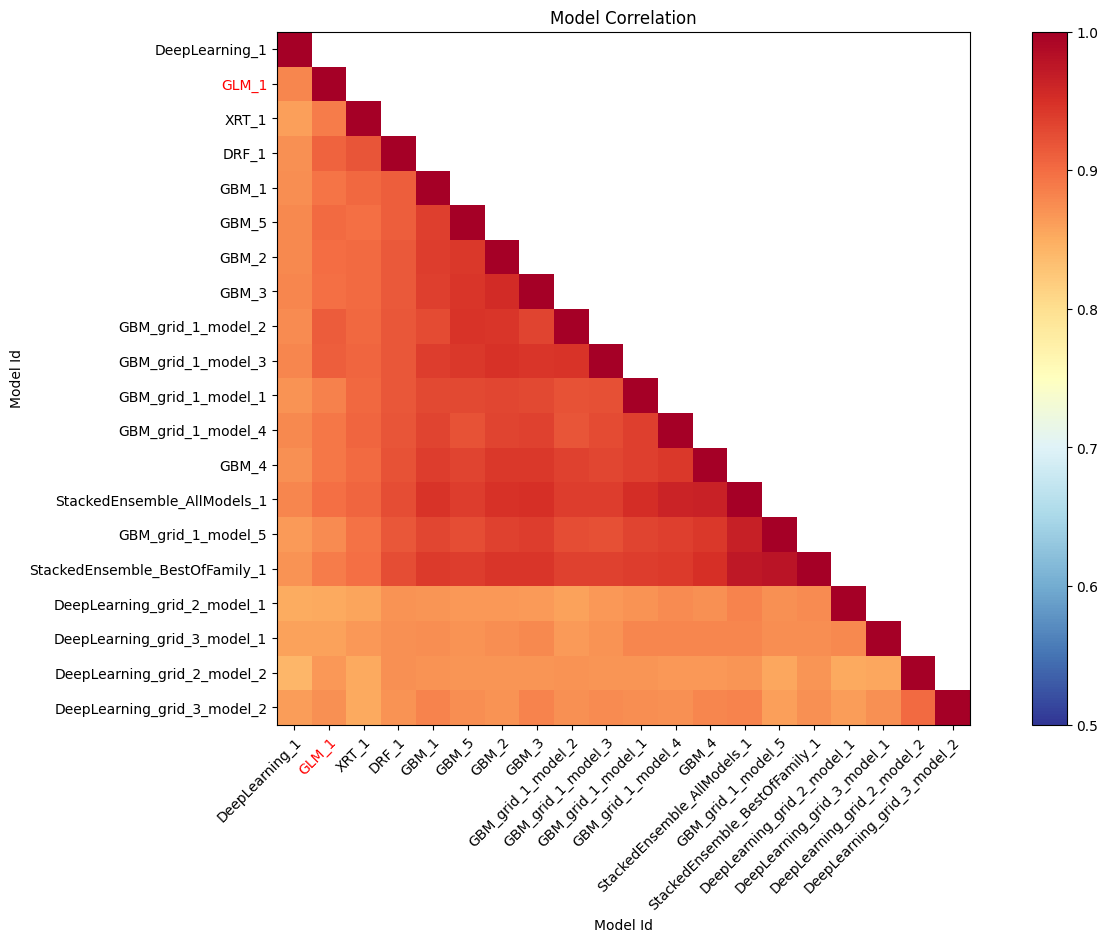

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

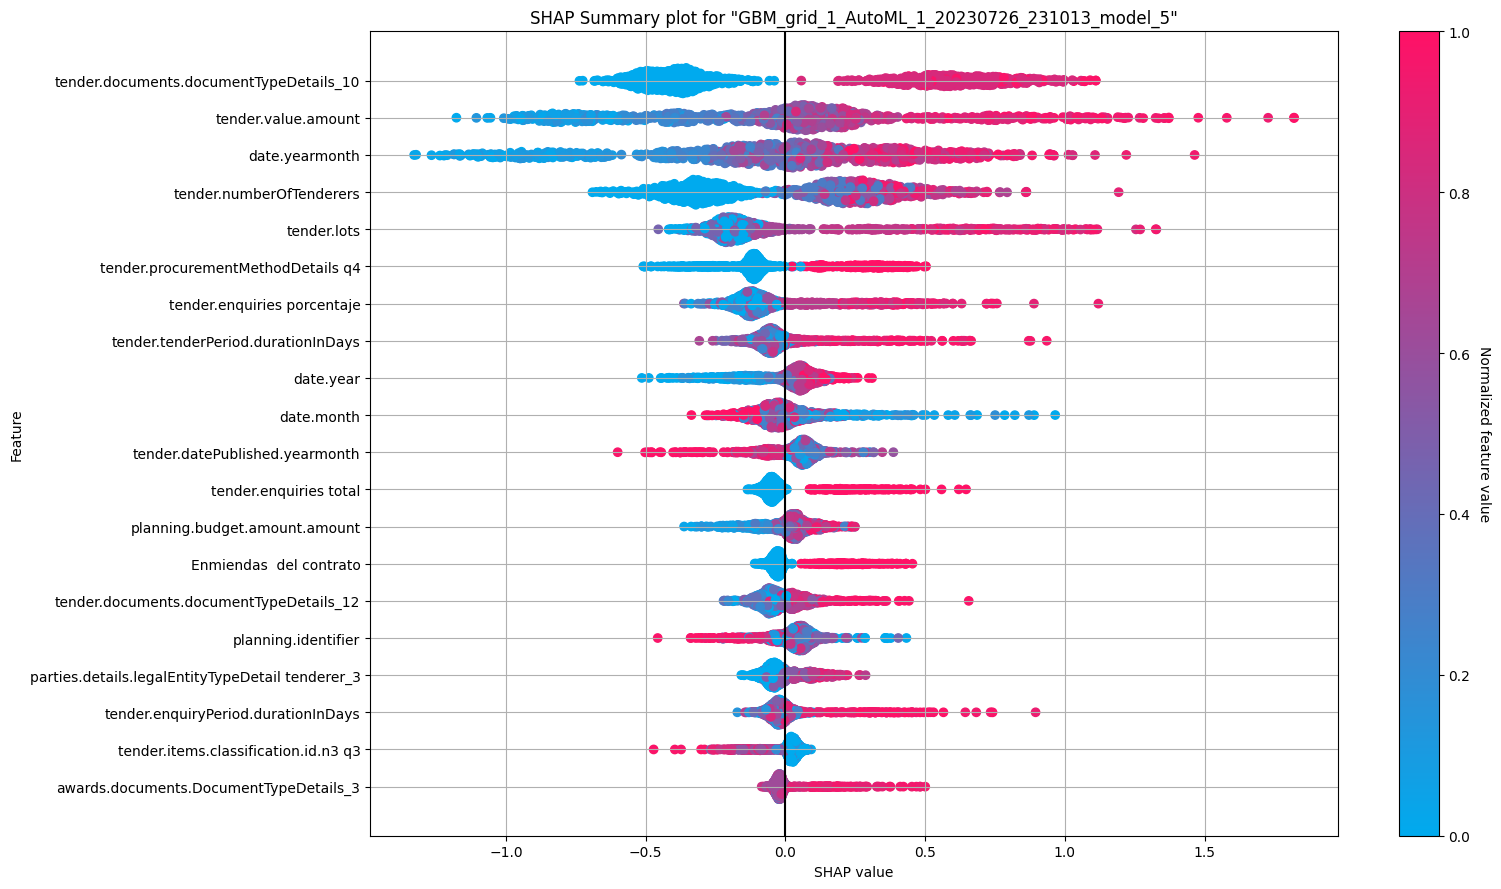

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

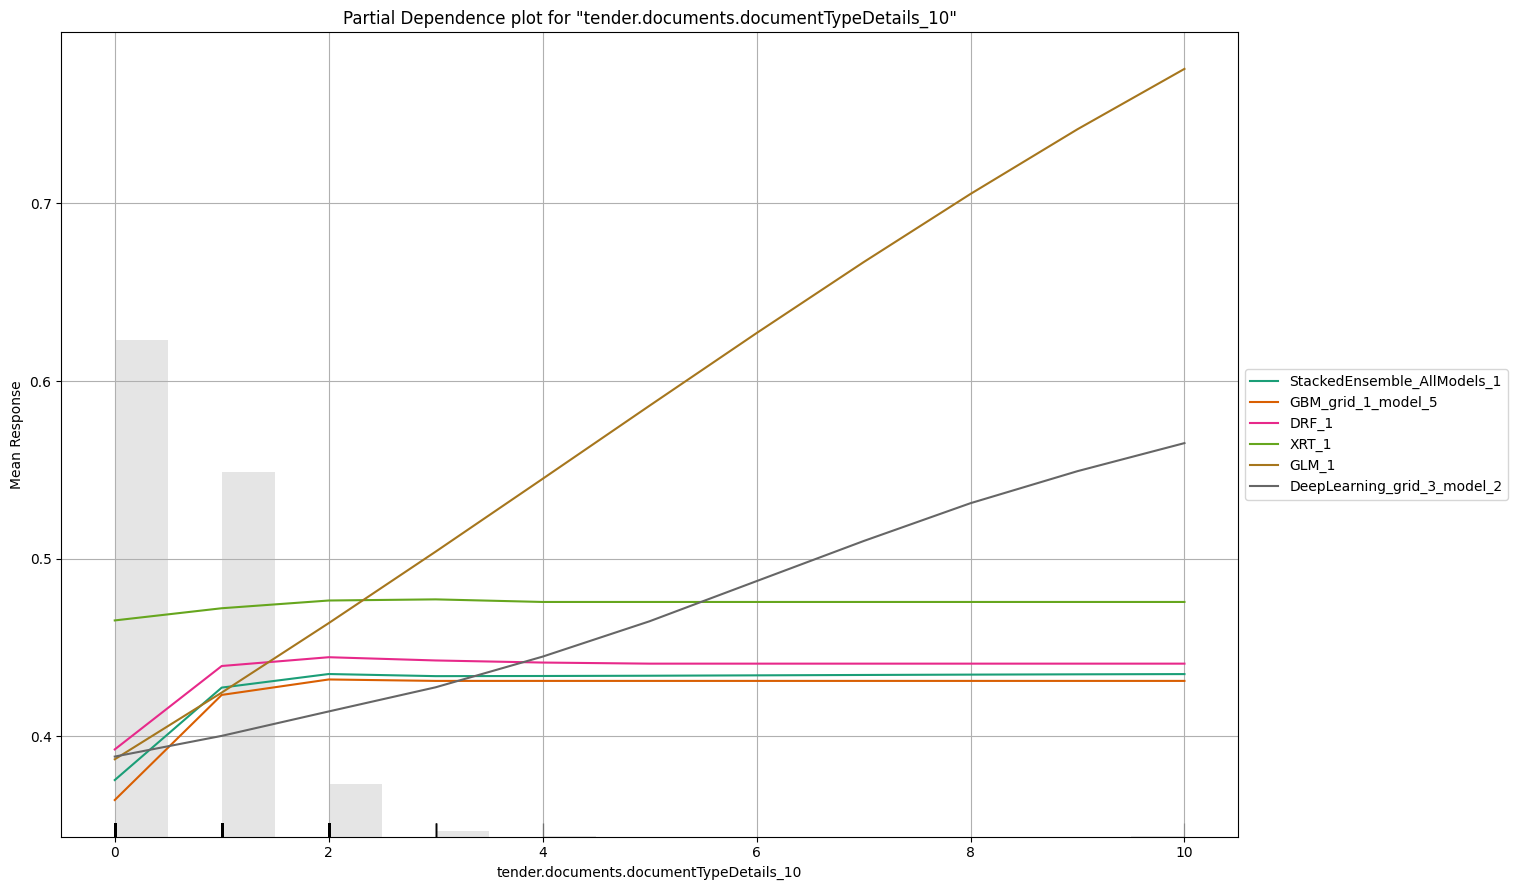

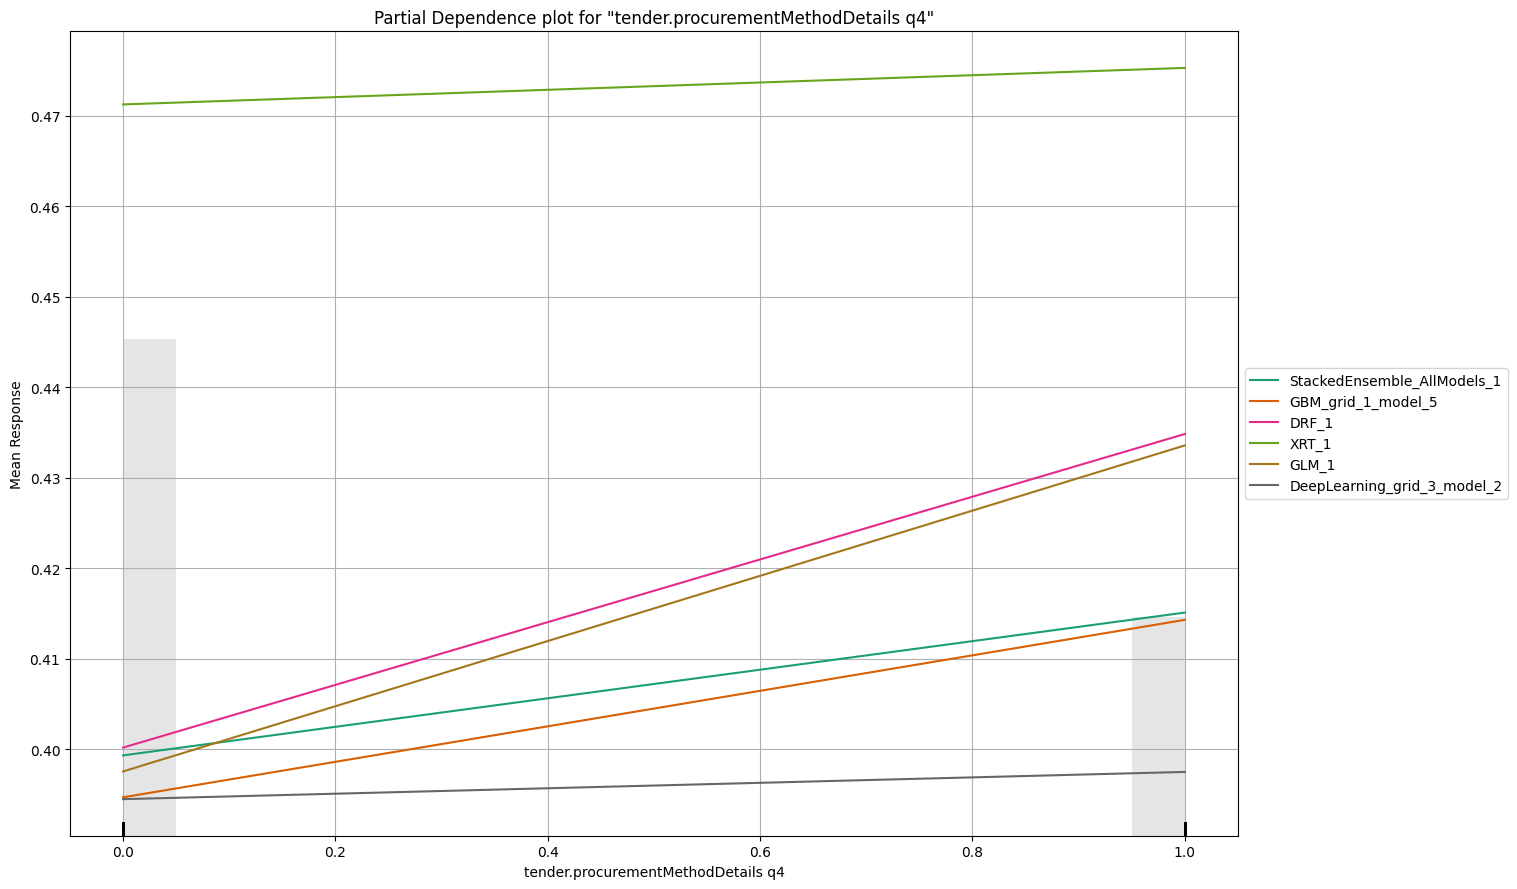

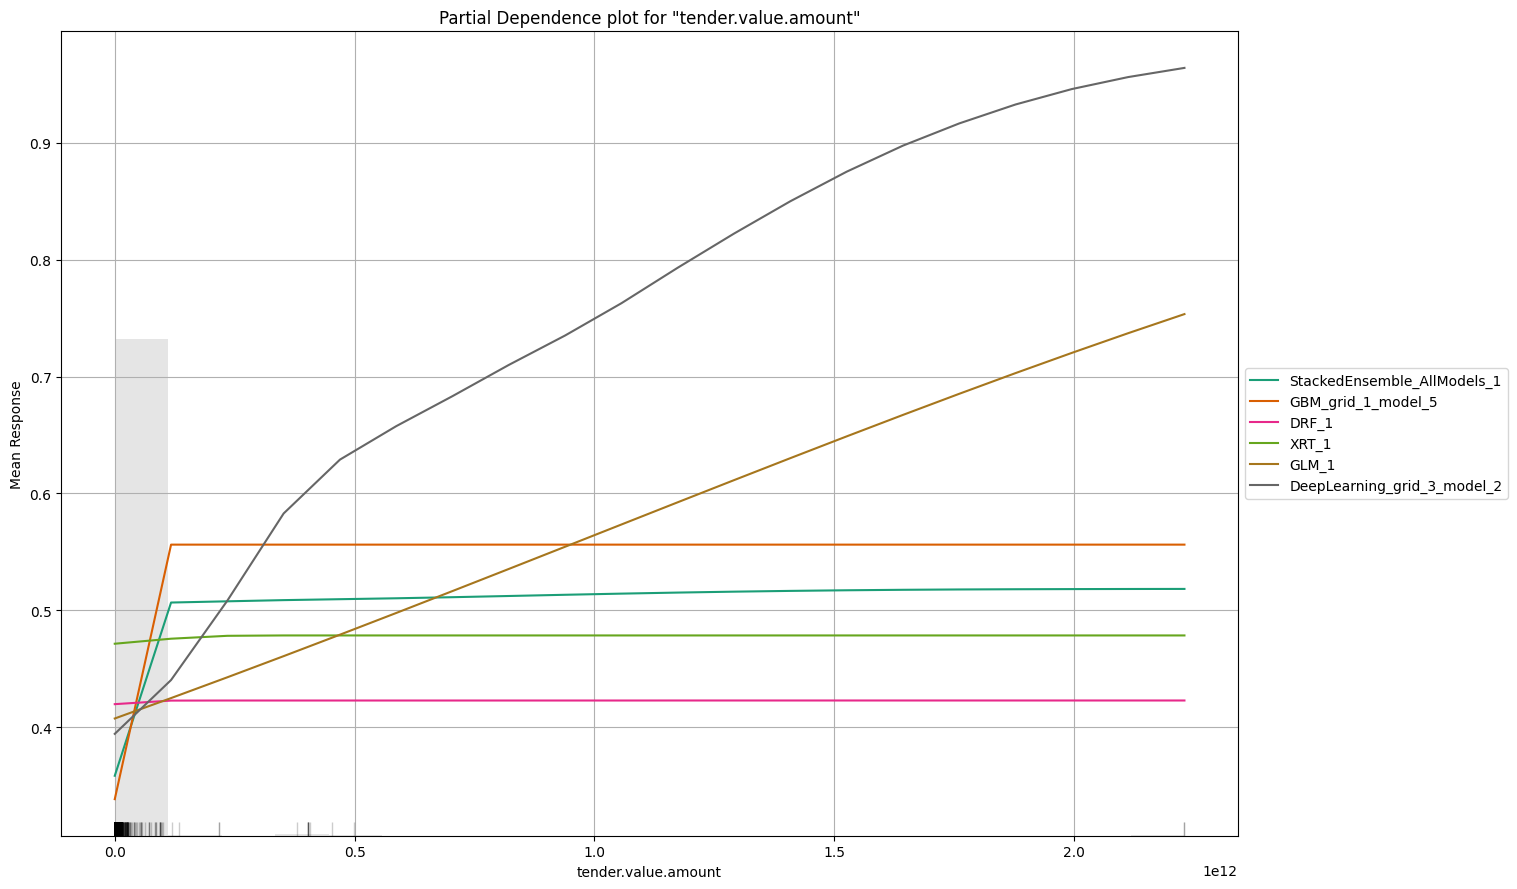

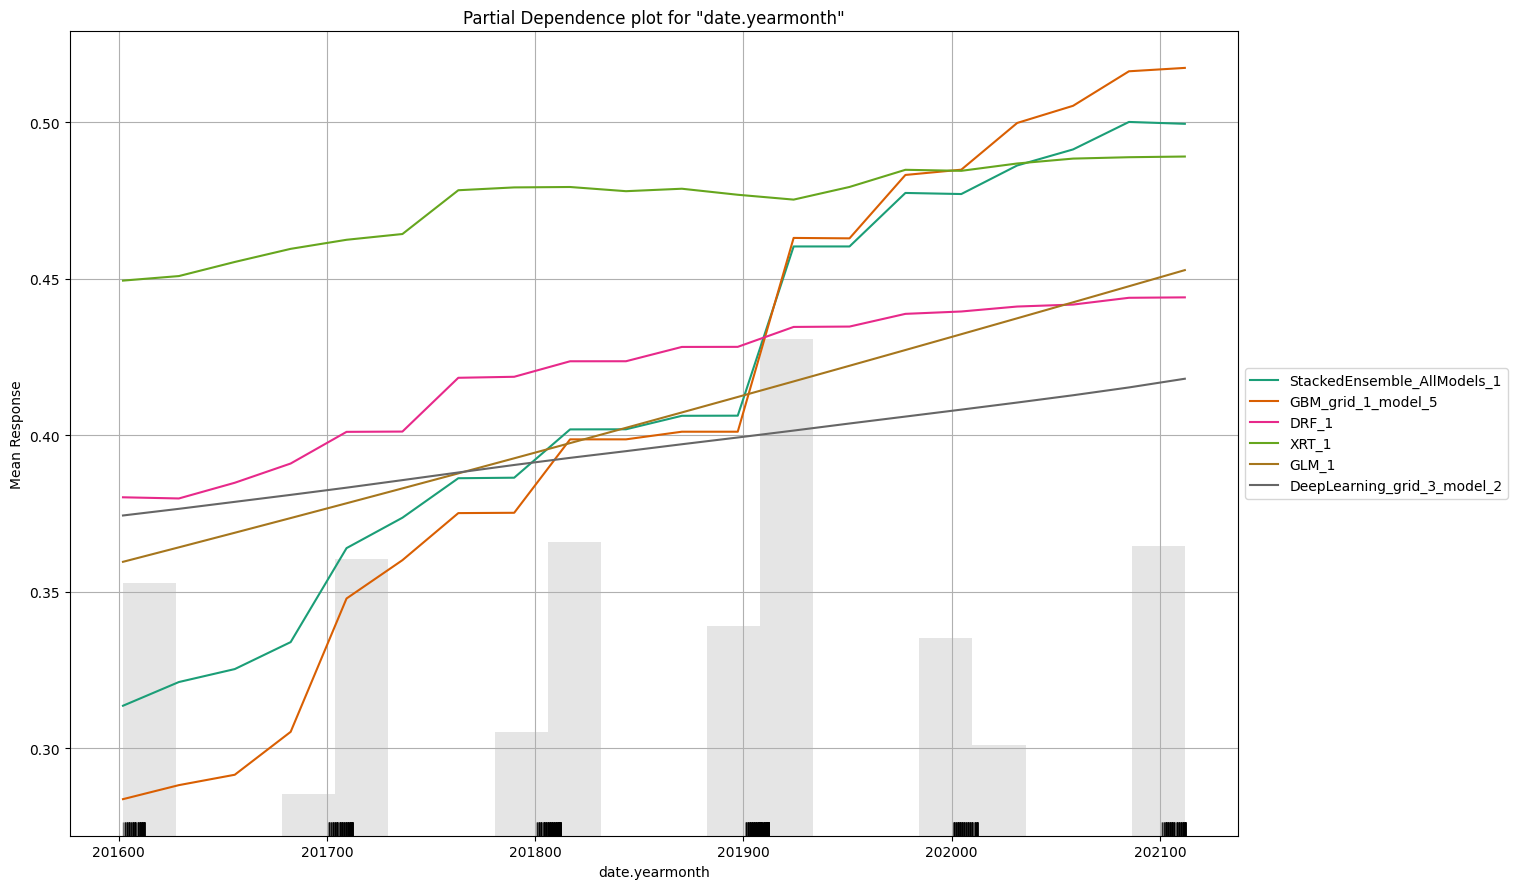

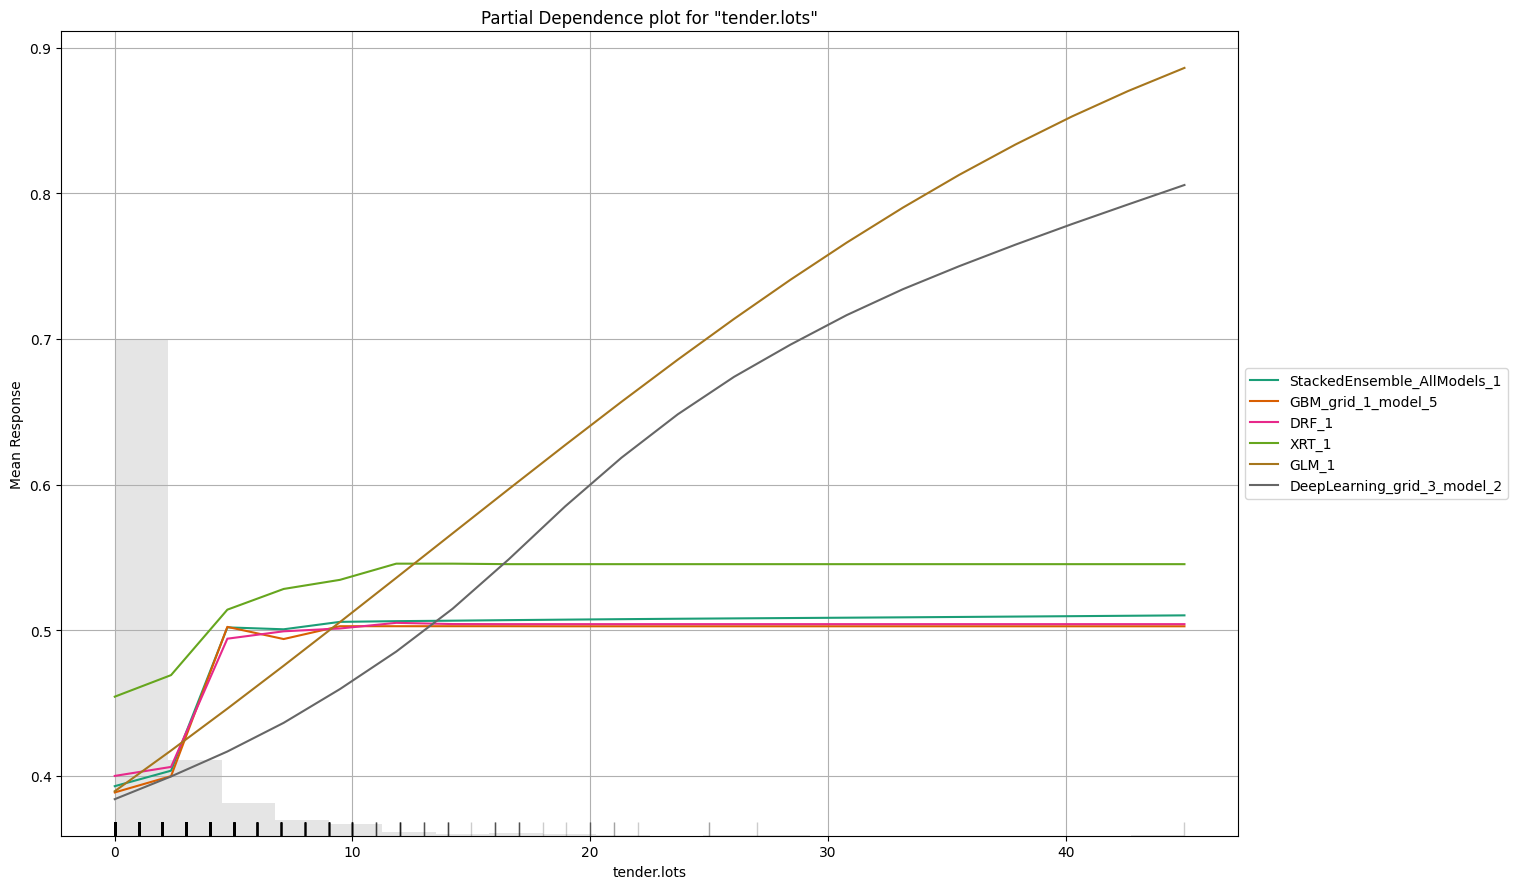

In [6]:
exa = aml.explain(test)


In [7]:
model_path = h2o.save_model(model=aml.leader, path="train2021/randomOverSamplingModel", force=True)

In [8]:
print(model_path)

/Users/davidnunez/Desktop/tesis/tesis-model/Training/train2021/randomOverSamplingModel/StackedEnsemble_AllModels_1_AutoML_1_20230726_231013
